# Vietnamese Sentiment Analysis - UIT-VSFC

## Approach: SVM + XGBoost Ensemble

**Method:**
- Model 1: Linear SVM with TF-IDF (word 1-2 grams + char 3-5 grams)
- Model 2: XGBoost with class weights
- Ensemble: Soft voting (SVM=0.7, XGB=0.3)
- Data augmentation: Neutral class 4% to 8.5%

**Baseline:** MaxEnt F1=87.94%

## 1. Import Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV

# XGBoost
import xgboost as xgb

# Set random seeds
np.random.seed(42)
random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Load Data

In [41]:
def load_data(base_path, split='train'):
    """
    Load dữ liệu từ thư mục
    """
    path = f"{base_path}/{split}"
    
    with open(f"{path}/sents.txt", 'r', encoding='utf-8') as f:
        sentences = [line.strip() for line in f]
    
    with open(f"{path}/sentiments.txt", 'r', encoding='utf-8') as f:
        sentiments = [int(line.strip()) for line in f]
    
    with open(f"{path}/topics.txt", 'r', encoding='utf-8') as f:
        topics = [int(line.strip()) for line in f]
    
    return sentences, sentiments, topics

DATA_PATH = "/kaggle/input/nlpnlp/data"

train_sents, train_sentiments, train_topics = load_data(DATA_PATH, 'train')
dev_sents, dev_sentiments, dev_topics = load_data(DATA_PATH, 'dev')
test_sents, test_sentiments, test_topics = load_data(DATA_PATH, 'test')

print(f"Training: {len(train_sents)}, Dev: {len(dev_sents)}, Test: {len(test_sents)}")

Training: 11426, Dev: 1583, Test: 3166


## 3. Data Distribution

TRAINING SET DISTRIBUTION
Negative: 5325 (46.60%)
Neutral: 458 (4.01%)
Positive: 5643 (49.39%)


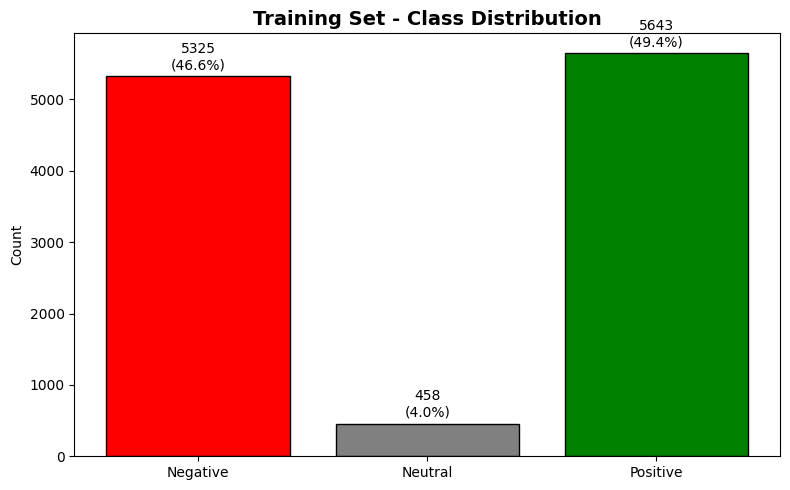

In [42]:
sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

print("="*70)
print("TRAINING SET DISTRIBUTION")
print("="*70)
unique, counts = np.unique(train_sentiments, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{sentiment_labels[u]}: {c} ({c/len(train_sentiments)*100:.2f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['red', 'gray', 'green']
ax.bar([sentiment_labels[u] for u in unique], counts, color=colors, edgecolor='black')
ax.set_title('Training Set - Class Distribution', fontweight='bold', fontsize=14)
ax.set_ylabel('Count')
for i, (u, c) in enumerate(zip(unique, counts)):
    ax.text(i, c + 100, f'{c}\n({c/len(train_sentiments)*100:.1f}%)', ha='center')
plt.tight_layout()
plt.show()

## 4. Data Augmentation

In [43]:
def augment_sentence(sentence, num_aug=1, aug_prob=0.3):
    """
    Augmentation techniques:
    - Random swap
    - Random deletion
    """
    augmented = []
    words = sentence.split()
    
    if len(words) < 3:
        return [sentence]
    
    for _ in range(num_aug):
        new_words = words.copy()
        
        # Random swap
        if random.random() < 0.5 and len(new_words) >= 2:
            n_swaps = max(1, int(len(new_words) * aug_prob))
            for _ in range(n_swaps):
                idx1, idx2 = random.sample(range(len(new_words)), 2)
                new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
        
        # Random deletion (with low probability)
        if random.random() < 0.3 and len(new_words) > 3:
            n_delete = max(1, int(len(new_words) * 0.1))
            for _ in range(n_delete):
                if len(new_words) > 3:
                    idx = random.randint(0, len(new_words) - 1)
                    new_words.pop(idx)
        
        aug_sent = ' '.join(new_words)
        if aug_sent != sentence:
            augmented.append(aug_sent)
    
    return [sentence] + augmented

def aggressive_augment_dataset(sentences, labels, target_neutral_ratio=0.12):
    """
    Aggressive augmentation cho Neutral class
    Target: Tăng Neutral từ 4% lên 12%
    """
    augmented_sents = []
    augmented_labels = []
    
    # Count classes
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))
    
    neutral_count = class_counts.get(1, 0)
    total_count = len(labels)
    
    # Calculate how many neutral samples we need
    target_neutral_count = int(total_count * target_neutral_ratio / (1 - target_neutral_ratio))
    needed_neutral = target_neutral_count - neutral_count
    aug_per_neutral = max(1, needed_neutral // neutral_count)
    
    print(f"Original Neutral: {neutral_count} ({neutral_count/total_count*100:.2f}%)")
    print(f"Target Neutral: {target_neutral_count} (~{target_neutral_ratio*100:.0f}%)")
    print(f"Augmentation per Neutral sample: {aug_per_neutral}x")
    
    for sent, label in zip(sentences, labels):
        if label == 1:  # Neutral class
            aug_sents = augment_sentence(sent, num_aug=aug_per_neutral, aug_prob=0.3)
            augmented_sents.extend(aug_sents)
            augmented_labels.extend([label] * len(aug_sents))
        else:
            augmented_sents.append(sent)
            augmented_labels.append(label)
    
    return augmented_sents, augmented_labels

# Apply augmentation
print("="*70)
print("APPLYING AGGRESSIVE AUGMENTATION")
print("="*70)

train_sents_aug, train_sentiments_aug = aggressive_augment_dataset(
    train_sents, train_sentiments, target_neutral_ratio=0.12
)

print(f"\nOriginal training size: {len(train_sents)}")
print(f"Augmented training size: {len(train_sents_aug)}")

# Check new distribution
unique, counts = np.unique(train_sentiments_aug, return_counts=True)
print("\nNew distribution:")
for u, c in zip(unique, counts):
    print(f"{sentiment_labels[u]}: {c} ({c/len(train_sentiments_aug)*100:.2f}%)")

APPLYING AGGRESSIVE AUGMENTATION
Original Neutral: 458 (4.01%)
Target Neutral: 1558 (~12%)
Augmentation per Neutral sample: 2x

Original training size: 11426
Augmented training size: 11985

New distribution:
Negative: 5325 (44.43%)
Neutral: 1017 (8.49%)
Positive: 5643 (47.08%)


## 5. Feature Engineering

In [44]:
# TF-IDF Vectorizers with different configurations

# Word-level (unigrams + bigrams)
tfidf_word = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),  # unigrams + bigrams like MaxEnt
    min_df=2,
    max_df=0.9,
    sublinear_tf=True
)

# Character-level (for capturing morphology)
tfidf_char = TfidfVectorizer(
    max_features=10000,
    analyzer='char',
    ngram_range=(3, 5),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True
)

print("Fitting TF-IDF vectorizers...")

# Fit on augmented training data
X_train_word = tfidf_word.fit_transform(train_sents_aug)
X_train_char = tfidf_char.fit_transform(train_sents_aug)

# Transform dev and test
X_dev_word = tfidf_word.transform(dev_sents)
X_dev_char = tfidf_char.transform(dev_sents)

X_test_word = tfidf_word.transform(test_sents)
X_test_char = tfidf_char.transform(test_sents)

# Combined features (horizontal stacking)
from scipy.sparse import hstack

X_train_combined = hstack([X_train_word, X_train_char])
X_dev_combined = hstack([X_dev_word, X_dev_char])
X_test_combined = hstack([X_test_word, X_test_char])

y_train = np.array(train_sentiments_aug)
y_dev = np.array(dev_sentiments)
y_test = np.array(test_sentiments)

print(f"\nFeature dimensions:")
print(f"Word features: {X_train_word.shape}")
print(f"Char features: {X_train_char.shape}")
print(f"Combined features: {X_train_combined.shape}")

Fitting TF-IDF vectorizers...

Feature dimensions:
Word features: (11985, 13820)
Char features: (11985, 10000)
Combined features: (11985, 23820)


## 6. Model 1: Linear SVM

In [45]:
print("="*70)
print("TRAINING MODEL 1: LINEAR SVM")
print("="*70)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("\nClass weights:")
for label, weight in class_weight_dict.items():
    print(f"{sentiment_labels[label]}: {weight:.3f}")

# Train Linear SVM
svm_model = LinearSVC(
    C=0.5,  # Regularization
    class_weight=class_weight_dict,
    max_iter=5000,
    random_state=42
)

print("\nTraining SVM...")
svm_model.fit(X_train_combined, y_train)

# Wrap with CalibratedClassifierCV to get probability estimates
print("Calibrating SVM for probability estimates...")
svm_calibrated = CalibratedClassifierCV(svm_model, cv=3)
svm_calibrated.fit(X_train_combined, y_train)

print("\nSVM training completed!")

TRAINING MODEL 1: LINEAR SVM

Class weights:
Negative: 0.750
Neutral: 3.928
Positive: 0.708

Training SVM...
Calibrating SVM for probability estimates...

SVM training completed!


### SVM Results

In [46]:
y_pred_svm = svm_calibrated.predict(X_test_combined)
y_pred_svm_proba = svm_calibrated.predict_proba(X_test_combined)

# Overall metrics
precision_overall, recall_overall, f1_overall, _ = precision_recall_fscore_support(
    y_test, y_pred_svm, average='weighted'
)

# Per-class metrics
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    y_test, y_pred_svm, average=None
)

# Baseline values
baseline = {
    'precision': [87.69, 50.00, 91.69, 87.71],
    'recall': [93.54, 25.75, 90.94, 88.66],
    'f1': [90.52, 33.99, 91.32, 87.94]
}

# Results table
print("="*70)
print("SVM RESULTS")
print("="*70)
print(f"{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)
classes_names = ['Negative', 'Neutral', 'Positive']
for i, cls in enumerate(classes_names):
    print(f"{cls:<12} {precision_per_class[i]*100:>6.2f}% {recall_per_class[i]*100:>6.2f}% {f1_per_class[i]*100:>6.2f}%")
print("-" * 70)
print(f"{'Overall':<12} {precision_overall*100:>6.2f}% {recall_overall*100:>6.2f}% {f1_overall*100:>6.2f}%")
print(f"{'Baseline':<12} {baseline['precision'][3]:>6.2f}% {baseline['recall'][3]:>6.2f}% {baseline['f1'][3]:>6.2f}%")
print(f"{'Improvement':<12} {precision_overall*100-baseline['precision'][3]:>+6.2f}% {recall_overall*100-baseline['recall'][3]:>+6.2f}% {f1_overall*100-baseline['f1'][3]:>+6.2f}%")
print("="*70)

SVM RESULTS
Class        Precision    Recall       F1-Score    
----------------------------------------------------------------------
Negative      87.83%  94.75%  91.16%
Neutral       56.38%  31.74%  40.61%
Positive      93.56%  91.32%  92.43%
----------------------------------------------------------------------
Overall       89.05%  89.70%  89.13%
Baseline      87.71%  88.66%  87.94%
Improvement   +1.34%  +1.04%  +1.19%


## 7. Model 2: XGBoost

In [47]:
print("="*70)
print("TRAINING MODEL 2: XGBOOST")
print("="*70)

# Calculate scale_pos_weight for each class
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# For multiclass, we use sample_weight instead
sample_weights = np.array([class_weights[label] for label in y_train])

# XGBoost parameters
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'tree_method': 'hist',  # Faster for large datasets
    'eval_metric': 'mlogloss'
}

print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(**xgb_params)

xgb_model.fit(
    X_train_combined, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_dev_combined, y_dev)],
    early_stopping_rounds=30,
    verbose=50
)

print("\nXGBoost training completed!")

TRAINING MODEL 2: XGBOOST
Training XGBoost...
[0]	validation_0-mlogloss:1.03328
[50]	validation_0-mlogloss:0.42902
[100]	validation_0-mlogloss:0.35507
[150]	validation_0-mlogloss:0.32248
[200]	validation_0-mlogloss:0.30473
[250]	validation_0-mlogloss:0.29477
[299]	validation_0-mlogloss:0.28723

XGBoost training completed!


### XGBoost Results

In [48]:
y_pred_xgb = xgb_model.predict(X_test_combined)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_combined)

# Metrics
precision_overall_xgb, recall_overall_xgb, f1_overall_xgb, _ = precision_recall_fscore_support(
    y_test, y_pred_xgb, average='weighted'
)
precision_per_class_xgb, recall_per_class_xgb, f1_per_class_xgb, _ = precision_recall_fscore_support(
    y_test, y_pred_xgb, average=None
)

# Results table
print("="*70)
print("XGBOOST RESULTS")
print("="*70)
print(f"{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)
for i, cls in enumerate(classes_names):
    print(f"{cls:<12} {precision_per_class_xgb[i]*100:>6.2f}% {recall_per_class_xgb[i]*100:>6.2f}% {f1_per_class_xgb[i]*100:>6.2f}%")
print("-" * 70)
print(f"{'Overall':<12} {precision_overall_xgb*100:>6.2f}% {recall_overall_xgb*100:>6.2f}% {f1_overall_xgb*100:>6.2f}%")
print(f"{'Baseline':<12} {baseline['precision'][3]:>6.2f}% {baseline['recall'][3]:>6.2f}% {baseline['f1'][3]:>6.2f}%")
print(f"{'Improvement':<12} {precision_overall_xgb*100-baseline['precision'][3]:>+6.2f}% {recall_overall_xgb*100-baseline['recall'][3]:>+6.2f}% {f1_overall_xgb*100-baseline['f1'][3]:>+6.2f}%")
print("="*70)

XGBOOST RESULTS
Class        Precision    Recall       F1-Score    
----------------------------------------------------------------------
Negative      88.91%  90.49%  89.69%
Neutral       37.23%  51.50%  43.22%
Positive      93.87%  88.62%  91.17%
----------------------------------------------------------------------
Overall       88.68%  87.49%  87.98%
Baseline      87.71%  88.66%  87.94%
Improvement   +0.97%  -1.17%  +0.04%


## 8. Ensemble: Soft Voting

In [49]:
print("="*70)
print("ENSEMBLE: SOFT VOTING")
print("="*70)

# Try different weight combinations
weight_combinations = [
    (0.5, 0.5),   # Equal weights
    (0.6, 0.4),   # More weight on SVM
    (0.4, 0.6),   # More weight on XGBoost
    (0.7, 0.3),   # Heavy SVM
]

best_f1 = 0
best_weights = None
best_pred = None

for w_svm, w_xgb in weight_combinations:
    # Weighted average of probabilities
    y_pred_ensemble_proba = w_svm * y_pred_svm_proba + w_xgb * y_pred_xgb_proba
    y_pred_ensemble = np.argmax(y_pred_ensemble_proba, axis=1)
    
    # Calculate F1
    _, _, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_ensemble, average='weighted'
    )
    
    print(f"Weights (SVM={w_svm}, XGB={w_xgb}): F1 = {f1*100:.2f}%")
    
    if f1 > best_f1:
        best_f1 = f1
        best_weights = (w_svm, w_xgb)
        best_pred = y_pred_ensemble

print(f"\nBest weights: SVM={best_weights[0]}, XGB={best_weights[1]}")
print(f"Best F1: {best_f1*100:.2f}%")

ENSEMBLE: SOFT VOTING
Weights (SVM=0.5, XGB=0.5): F1 = 89.34%
Weights (SVM=0.6, XGB=0.4): F1 = 89.56%
Weights (SVM=0.4, XGB=0.6): F1 = 88.81%
Weights (SVM=0.7, XGB=0.3): F1 = 89.73%

Best weights: SVM=0.7, XGB=0.3
Best F1: 89.73%


## 9. Final Results

In [50]:
# Metrics
precision_overall_ens, recall_overall_ens, f1_overall_ens, _ = precision_recall_fscore_support(
    y_test, best_pred, average='weighted'
)
precision_per_class_ens, recall_per_class_ens, f1_per_class_ens, _ = precision_recall_fscore_support(
    y_test, best_pred, average=None
)

# Results table
print("="*70)
print("ENSEMBLE RESULTS (SVM=0.7, XGB=0.3)")
print("="*70)
print(f"{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)
for i, cls in enumerate(classes_names):
    print(f"{cls:<12} {precision_per_class_ens[i]*100:>6.2f}% {recall_per_class_ens[i]*100:>6.2f}% {f1_per_class_ens[i]*100:>6.2f}%")
print("-" * 70)
print(f"{'Overall':<12} {precision_overall_ens*100:>6.2f}% {recall_overall_ens*100:>6.2f}% {f1_overall_ens*100:>6.2f}%")
print(f"{'Baseline':<12} {baseline['precision'][3]:>6.2f}% {baseline['recall'][3]:>6.2f}% {baseline['f1'][3]:>6.2f}%")
print(f"{'Improvement':<12} {precision_overall_ens*100-baseline['precision'][3]:>+6.2f}% {recall_overall_ens*100-baseline['recall'][3]:>+6.2f}% {f1_overall_ens*100-baseline['f1'][3]:>+6.2f}%")
print("="*70)

# Store for later use
ensemble_metrics = {
    'precision': [precision_per_class_ens[0]*100, precision_per_class_ens[1]*100, 
                  precision_per_class_ens[2]*100, precision_overall_ens*100],
    'recall': [recall_per_class_ens[0]*100, recall_per_class_ens[1]*100, 
               recall_per_class_ens[2]*100, recall_overall_ens*100],
    'f1': [f1_per_class_ens[0]*100, f1_per_class_ens[1]*100, 
           f1_per_class_ens[2]*100, f1_overall_ens*100]
}

ENSEMBLE RESULTS (SVM=0.7, XGB=0.3)
Class        Precision    Recall       F1-Score    
----------------------------------------------------------------------
Negative      88.76%  94.75%  91.66%
Neutral       55.37%  40.12%  46.53%
Positive      94.03%  91.13%  92.56%
----------------------------------------------------------------------
Overall       89.65%  90.05%  89.73%
Baseline      87.71%  88.66%  87.94%
Improvement   +1.94%  +1.39%  +1.79%


## 10. Confusion Matrix

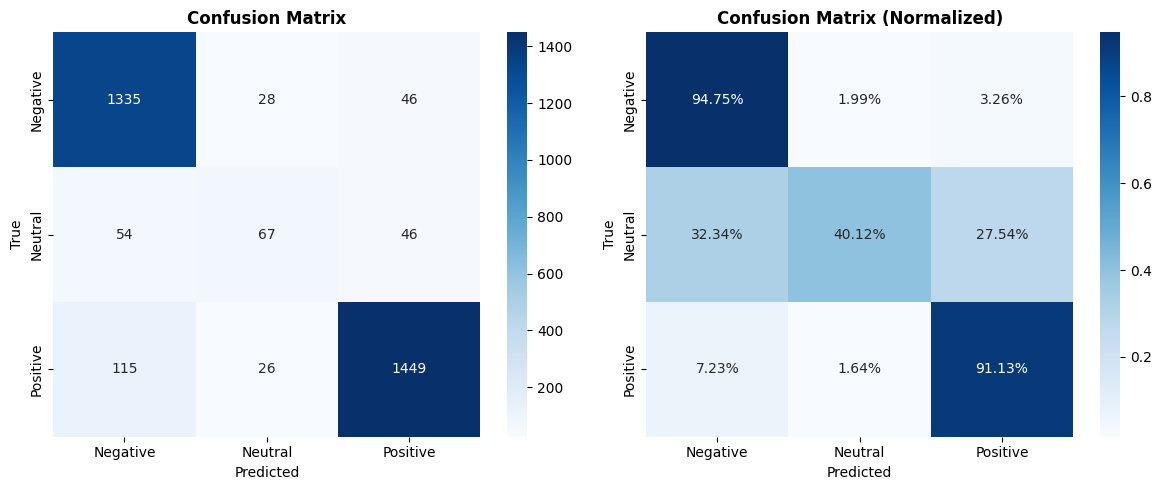

In [51]:
cm = confusion_matrix(y_test, best_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
classes = ['Negative', 'Neutral', 'Positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=classes, yticklabels=classes)
axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=classes, yticklabels=classes)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

In [52]:
# Create comprehensive comparison dataframe
import pandas as pd

# Per-class comparison
comparison_data = []

classes = ['Negative', 'Neutral', 'Positive']
metrics = ['Precision', 'Recall', 'F1-Score']

for i, cls in enumerate(classes):
    for j, metric in enumerate(metrics):
        if j == 0:  # Precision
            baseline_val = baseline['precision'][i]
            ensemble_val = ensemble_metrics['precision'][i]
        elif j == 1:  # Recall
            baseline_val = baseline['recall'][i]
            ensemble_val = ensemble_metrics['recall'][i]
        else:  # F1
            baseline_val = baseline['f1'][i]
            ensemble_val = ensemble_metrics['f1'][i]
        
        comparison_data.append({
            'Class': cls,
            'Metric': metric,
            'Baseline (%)': baseline_val,
            'Ensemble (%)': ensemble_val,
            'Improvement (%)': ensemble_val - baseline_val
        })

# Overall metrics
for j, metric in enumerate(metrics):
    if j == 0:  # Precision
        baseline_val = baseline['precision'][3]
        ensemble_val = ensemble_metrics['precision'][3]
    elif j == 1:  # Recall
        baseline_val = baseline['recall'][3]
        ensemble_val = ensemble_metrics['recall'][3]
    else:  # F1
        baseline_val = baseline['f1'][3]
        ensemble_val = ensemble_metrics['f1'][3]
    
    comparison_data.append({
        'Class': 'Overall',
        'Metric': metric,
        'Baseline (%)': baseline_val,
        'Ensemble (%)': ensemble_val,
        'Improvement (%)': ensemble_val - baseline_val
    })

df_comparison = pd.DataFrame(comparison_data)

print("="*90)
print("COMPREHENSIVE METRICS COMPARISON: BASELINE vs ENSEMBLE")
print("="*90)
print(df_comparison.to_string(index=False))
print("="*90)

# Pivot table for better visualization
print("\n" + "="*90)
print("PIVOT VIEW - ALL METRICS BY CLASS")
print("="*90)

for cls in classes + ['Overall']:
    print(f"\n{cls}:")
    print("-" * 70)
    print(f"{'Metric':<15} {'Baseline':<15} {'Ensemble':<15} {'Improvement'}")
    print("-" * 70)
    
    cls_data = df_comparison[df_comparison['Class'] == cls]
    for _, row in cls_data.iterrows():
        print(f"{row['Metric']:<15} {row['Baseline (%)']:>6.2f}% {row['Ensemble (%)']:>6.2f}% {row['Improvement (%)']:>+6.2f}%")

# Save comparison table
df_comparison.to_csv('metrics_comparison_table.csv', index=False)
print("\n✓ Metrics comparison table saved to 'metrics_comparison_table.csv'")

COMPREHENSIVE METRICS COMPARISON: BASELINE vs ENSEMBLE
   Class    Metric  Baseline (%)  Ensemble (%)  Improvement (%)
Negative Precision         87.69     88.763298         1.073298
Negative    Recall         93.54     94.748048         1.208048
Negative  F1-Score         90.52     91.658084         1.138084
 Neutral Precision         50.00     55.371901         5.371901
 Neutral    Recall         25.75     40.119760        14.369760
 Neutral  F1-Score         33.99     46.527778        12.537778
Positive Precision         91.69     94.029851         2.339851
Positive    Recall         90.94     91.132075         0.192075
Positive  F1-Score         91.32     92.558288         1.238288
 Overall Precision         87.71     89.646891         1.936891
 Overall    Recall         88.66     90.050537         1.390537
 Overall  F1-Score         87.94     89.729646         1.789646

PIVOT VIEW - ALL METRICS BY CLASS

Negative:
-------------------------------------------------------------------


PER-CLASS F1-SCORE COMPARISON
Class        Baseline     Ensemble     Improvement 
----------------------------------------------------------------------
Negative      90.52%  91.66%  +1.14%
Neutral       33.99%  46.53% +12.54%
Positive      91.32%  92.56%  +1.24%


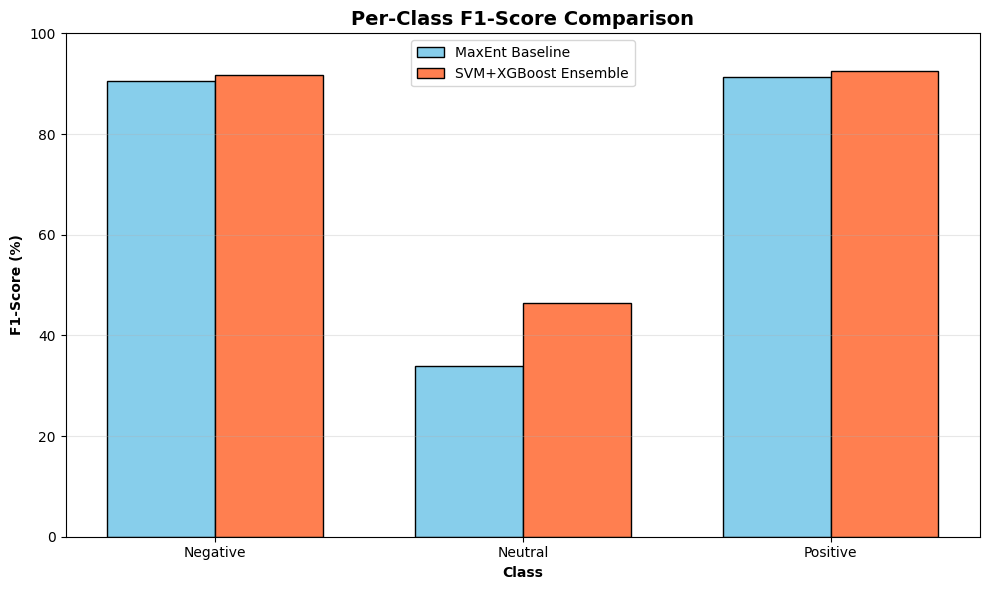

In [53]:
# Per-class F1 scores
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    y_test, best_pred, average=None
)

# Baseline results
baseline_f1 = {'Negative': 90.52, 'Neutral': 33.99, 'Positive': 91.32}

print("\n" + "="*70)
print("PER-CLASS F1-SCORE COMPARISON")
print("="*70)
print(f"{'Class':<12} {'Baseline':<12} {'Ensemble':<12} {'Improvement':<12}")
print("-" * 70)

classes = ['Negative', 'Neutral', 'Positive']
for i, cls in enumerate(classes):
    baseline_val = baseline_f1[cls]
    our_val = f1_per_class[i] * 100
    improvement = our_val - baseline_val
    
    print(f"{cls:<12} {baseline_val:>6.2f}% {our_val:>6.2f}% {improvement:>+6.2f}%")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(classes))
width = 0.35

baseline_vals = [baseline_f1[c] for c in classes]
our_vals = [f1_per_class[i]*100 for i in range(3)]

ax.bar(x - width/2, baseline_vals, width, label='MaxEnt Baseline', 
       color='skyblue', edgecolor='black')
ax.bar(x + width/2, our_vals, width, label='SVM+XGBoost Ensemble', 
       color='coral', edgecolor='black')

ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('F1-Score (%)', fontweight='bold')
ax.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

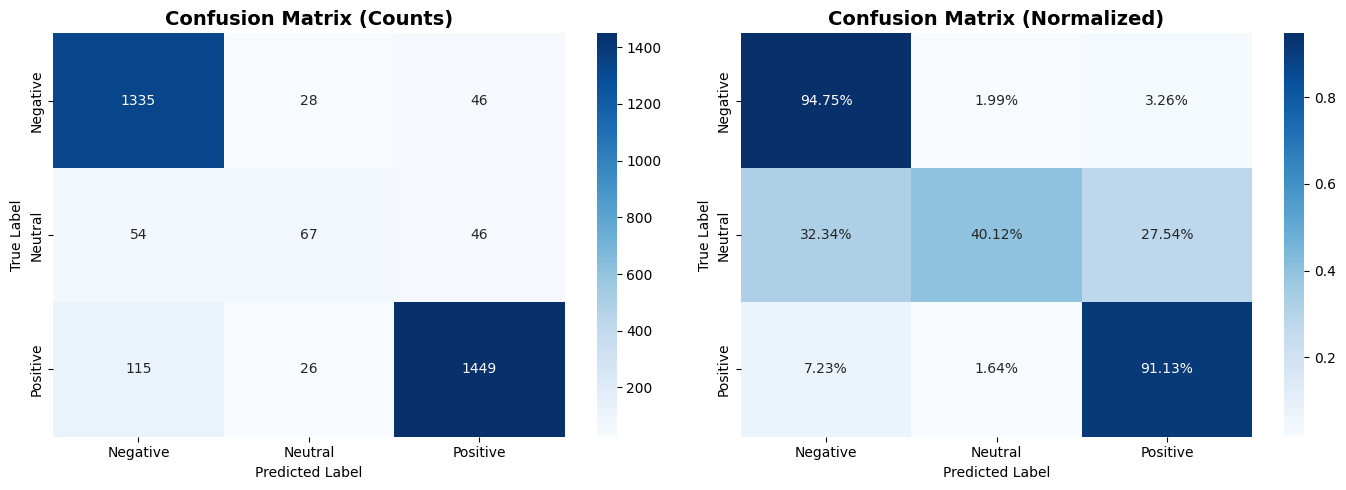

In [54]:
# Confusion matrix
cm = confusion_matrix(y_test, best_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=classes, yticklabels=classes)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=classes, yticklabels=classes)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 14. Save Results

**Lưu đầy đủ Precision, Recall, F1-score**

In [55]:
# Save predictions
results_df = pd.DataFrame({
    'sentence': test_sents,
    'true_label': [sentiment_labels[l] for l in y_test],
    'predicted_label': [sentiment_labels[l] for l in best_pred],
    'svm_prediction': [sentiment_labels[l] for l in y_pred_svm],
    'xgb_prediction': [sentiment_labels[l] for l in y_pred_xgb],
    'correct': y_test == best_pred
})

results_df.to_csv('ensemble_predictions.csv', index=False, encoding='utf-8-sig')
print("Predictions saved to 'ensemble_predictions.csv'")

# Save COMPREHENSIVE metrics with all 3 scores
import json

metrics_dict = {
    'model': 'SVM+XGBoost Ensemble',
    'ensemble_weights': {'svm': best_weights[0], 'xgb': best_weights[1]},
    
    # Overall metrics - ALL 3
    'overall': {
        'precision': precision_overall_ens * 100,
        'recall': recall_overall_ens * 100,
        'f1': f1_overall_ens * 100
    },
    
    # Per-class metrics - ALL 3
    'per_class': {
        'negative': {
            'precision': precision_per_class_ens[0] * 100,
            'recall': recall_per_class_ens[0] * 100,
            'f1': f1_per_class_ens[0] * 100
        },
        'neutral': {
            'precision': precision_per_class_ens[1] * 100,
            'recall': recall_per_class_ens[1] * 100,
            'f1': f1_per_class_ens[1] * 100
        },
        'positive': {
            'precision': precision_per_class_ens[2] * 100,
            'recall': recall_per_class_ens[2] * 100,
            'f1': f1_per_class_ens[2] * 100
        }
    },
    
    # Baseline comparison
    'baseline': {
        'precision': 87.71,
        'recall': 88.66,
        'f1': 87.94
    },
    
    # Improvements
    'improvement': {
        'precision': precision_overall_ens * 100 - 87.71,
        'recall': recall_overall_ens * 100 - 88.66,
        'f1': f1_overall_ens * 100 - 87.94
    },
    
    # Individual model performance
    'individual_models': {
        'svm': {
            'precision': precision_overall * 100,
            'recall': recall_overall * 100,
            'f1': f1_overall * 100
        },
        'xgboost': {
            'precision': precision_overall_xgb * 100,
            'recall': recall_overall_xgb * 100,
            'f1': f1_overall_xgb * 100
        }
    }
}

with open('ensemble_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)
    
print("Metrics saved to 'ensemble_metrics.json'")

# Print summary
print("\n" + "="*70)
print("SAVED METRICS SUMMARY")
print("="*70)
print(f"\nOverall Performance:")
print(f"  Precision: {precision_overall_ens*100:.2f}%")
print(f"  Recall:    {recall_overall_ens*100:.2f}%")
print(f"  F1-Score:  {f1_overall_ens*100:.2f}%")
print(f"\nImprovements over Baseline:")
print(f"  Precision: {precision_overall_ens*100 - 87.71:+.2f}%")
print(f"  Recall:    {recall_overall_ens*100 - 88.66:+.2f}%")
print(f"  F1-Score:  {f1_overall_ens*100 - 87.94:+.2f}%")

Predictions saved to 'ensemble_predictions.csv'
Metrics saved to 'ensemble_metrics.json'

SAVED METRICS SUMMARY

Overall Performance:
  Precision: 89.65%
  Recall:    90.05%
  F1-Score:  89.73%

Improvements over Baseline:
  Precision: +1.94%
  Recall:    +1.39%
  F1-Score:  +1.79%
